<a href="https://colab.research.google.com/github/Charmie13/MSCI-641-Text-Analytics_Final-Project/blob/main/Neural_Networks_LSTM%2C_Bi_LSTM%2C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir data
!mkdir data/glove
!mkdir data/glove_twitter
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.twitter.27B.zip -d data/glove_twitter/
!unzip glove.6B.zip -d data/glove

--2022-08-08 07:04:13--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2022-08-08 07:04:13--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-08-08 07:04:13--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip -d data/wiki-news-vec/

--2022-08-08 07:12:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  44.5MB/s    in 15s     

2022-08-08 07:13:14 (44.4 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: data/wiki-news-vec/wiki-news-300d-1M.vec  


In [ ]:
import numpy as np, pandas as pd, csv, tensorflow as tf, gensim as gensim
from collections import Counter
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from score import report_score, score_submission
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [ ]:
def read_data(path1, path2):
  train = pd.read_csv(path1)
  test = pd.read_csv(path2)
  print("Train Shape" + str(train.shape))
  print("Test Shape" + str(test.shape))
  return train, test

In [ ]:
#separate the text data based on the space
def sequentialize_data(train, test):
  train_head_seq = [text_to_word_sequence(head) for head in train['Headline']]
  train_body_seq = [text_to_word_sequence(body) for body in train['articleBody']]
  test_head_seq = [text_to_word_sequence(head) for head in test['Headline']]
  test_body_seq = [text_to_word_sequence(body) for body in test['articleBody']]
  print("Train head sequence " +str(len(train_head_seq)))
  print("Train body sequence " +str(len(train_body_seq)))
  print("Test head sequence " +str(len(test_head_seq)))
  print("Test body sequence " +str(len(test_body_seq)))
  return (train_head_seq, train_body_seq, test_head_seq, test_body_seq)

In [ ]:
def concatenate_train_data(train_head_seq, train_body_seq):
  words = []
  for i in range(len(train_head_seq)):    
      words.append(train_head_seq[i])
  print("Length of words after adding Headlines" + str(len(words)))
  print(words[:250])
  for i in range(len(train_body_seq)):
    words.append(train_body_seq[i])
  print("Length of words after adding Headlines" + str(len(words)))
  print(words[250:500])
  return words

In [ ]:
# vectorize the data - the sequence that has been received has to now be converted into a set of vectors for the tensor to process.
def vectorize_data(list):
  symbols = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
  tokenizer = Tokenizer(num_words= 30000, filters = symbols)
  tokenizer.fit_on_texts([word for word in words])
  # print("Size of Vocabulary:", len(tokenizer.word_index))
  return tokenizer

In [ ]:
def extend_data(train_head_seq, test_head_seq, train_body_seq, train, test, tokenizer):
  train_seq = [list(i) for i in train_head_seq]
  for i in range(len(train_head_seq)):
      train_seq[i].extend(train_body_seq[i]) 
  test_seq = [list(i) for i in test_head_seq]
  for i in range(len(test_head_seq)):
      test_seq[i].extend(test_body_seq[i])
  # print('After Sequentialization')
  # print("Length of train_seq " +str(len(train_seq)))
  # print("Length of test_seq " +str(len(test_seq)))
  X_train = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in train_seq])
  X_train = pad_sequences(X_train, maxlen = 128, padding = 'post', truncating = 'post')
  y_train = train['Stance']
  # print('Train data After Tokenization')
  # print("X_train Shape " + str(X_train.shape))
  # print("y_train Shape " + str(y_train.shape))
  X_test = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in test_seq])
  X_test = pad_sequences(X_test, maxlen = 128, padding = 'post', truncating = 'post')
  y_test = test['Stance']
  # print('Test data After Tokenization')
  # print("X_test Shape " + str(X_test.shape))
  # print("y_test Shape " + str(y_test.shape))
  encoder = LabelEncoder()
  encoder.fit(y_train)
  train_encoded = encoder.transform(y_train)
  y_train = to_categorical(train_encoded)
  print('Train Data After Encoding, \n')
  print("X_train Shape " + str(X_train.shape))
  print("X_test Shape " + str(X_test.shape))
  print("y_train Shape " + str(y_train.shape))
  print("y_test Shape " + str(y_test.shape)+'\n')
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.1)
  encoder = LabelEncoder()
  encoder.fit(y_test)
  test_encoded = encoder.transform(y_test)
  y_test = to_categorical(test_encoded)
  print('Train Data After Encoding and splitting, \n')
  print("X_train Shape " + str(X_train.shape))
  print("X_test Shape " + str(X_test.shape))
  print("y_train Shape " + str(y_train.shape))
  print("y_test Shape " + str(y_test.shape))
  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
i = 0
if i == 0:
  path1 = './train.csv'
elif i == -1: 
  path1 = './train_undersample.csv'
elif i == 1:
  path1 = './train_oversample.csv'
else:
  path1 = './train.csv'
train, test = read_data(path1, './test.csv')

Train Shape(49972, 4)
Test Shape(25413, 4)


In [ ]:
train_head_seq, train_body_seq, test_head_seq, test_body_seq = sequentialize_data(train, test)

Train head sequence 49972
Train body sequence 49972
Test head sequence 25413
Test body sequence 25413


In [ ]:
words = []
words = concatenate_train_data(train_head_seq, train_body_seq)

Length of words after adding Headlines49972
[['police', 'find', 'mass', 'graves', 'with', 'at', 'least', "'15", "bodies'", 'near', 'mexico', 'town', 'where', '43', 'students', 'disappeared', 'after', 'police', 'clash'], ['hundreds', 'of', 'palestinians', 'flee', 'floods', 'in', 'gaza', 'as', 'israel', 'opens', 'dams'], ['christian', 'bale', 'passes', 'on', 'role', 'of', 'steve', 'jobs', 'actor', 'reportedly', 'felt', 'he', "wasn't", 'right', 'for', 'part'], ['hbo', 'and', 'apple', 'in', 'talks', 'for', '15', 'month', 'apple', 'tv', 'streaming', 'service', 'launching', 'in', 'april'], ['spider', 'burrowed', 'through', "tourist's", 'stomach', 'and', 'up', 'into', 'his', 'chest'], ["'nasa", 'confirms', 'earth', 'will', 'experience', '6', 'days', 'of', 'total', 'darkness', 'in', "december'", 'fake', 'news', 'story', 'goes', 'viral'], ['accused', 'boston', 'marathon', 'bomber', 'severely', 'injured', 'in', 'prison', 'may', 'never', 'walk', 'or', 'talk', 'again'], ['identity', 'of', 'isis', 

In [ ]:
tokenizer = vectorize_data(words)
X_train, y_train, X_val, y_val, X_test, y_test = extend_data(train_head_seq, test_head_seq, train_body_seq, train, test, tokenizer)

Train Data After Encoding, 

X_train Shape (49972, 128)
X_test Shape (25413, 128)
y_train Shape (49972, 4)
y_test Shape (25413,)

Train Data After Encoding and splitting, 

X_train Shape (44974, 128)
X_test Shape (25413, 128)
y_train Shape (44974, 4)
y_test Shape (25413, 4)


In [ ]:
print(len(X_train))
print(len(y_train))

44974
44974


In [ ]:
glove_input_file = './data/glove_twitter/glove.twitter.27B.200d.txt'
word2vec_output_file = 'glove.200d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
weight_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 200)) 
for word, i in tokenizer.word_index.items():
    try:
        word_embeddings_vector = embeddings[word]
    except KeyError:
        word_embeddings_vector = None
    if word_embeddings_vector is not None:
        weight_matrix[i] = word_embeddings_vector
del embeddings

In [ ]:
model1 = Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 200, weights = [weight_matrix], trainable = True, mask_zero=True))
model1.add(LSTM(120, return_sequences = False))
model1.add(Dropout(rate = 0.3)) 
model1.add(Dense(4, activation='softmax'))
model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model1.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
pred = model1.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
model1.summary()
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
df_submit.to_csv('answer_BaseLSTM.csv', index = False, encoding = 'utf-8')
base_lstm_accuracy = history.history['accuracy']
base_lstm_validation = history.history['accuracy']
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)

Epoch 1/20
352/352 [==============================] - 12s 23ms/step - loss: 0.7199 - accuracy: 0.7420 - val_loss: 0.5824 - val_accuracy: 0.7977
Epoch 2/20
352/352 [==============================] - 6s 18ms/step - loss: 0.5382 - accuracy: 0.8022 - val_loss: 0.5062 - val_accuracy: 0.8211
Epoch 3/20
352/352 [==============================] - 7s 21ms/step - loss: 0.4623 - accuracy: 0.8276 - val_loss: 0.4649 - val_accuracy: 0.8357
Epoch 4/20
352/352 [==============================] - 7s 19ms/step - loss: 0.3952 - accuracy: 0.8498 - val_loss: 0.4324 - val_accuracy: 0.8425
Epoch 5/20
352/352 [==============================] - 7s 19ms/step - loss: 0.3425 - accuracy: 0.8689 - val_loss: 0.3940 - val_accuracy: 0.8625
Epoch 6/20
352/352 [==============================] - 7s 19ms/step - loss: 0.2978 - accuracy: 0.8842 - val_loss: 0.3803 - val_accuracy: 0.8623
Epoch 7/20
352/352 [==============================] - 7s 19ms/step - loss: 0.2610 - accuracy: 0.8969 - val_loss: 0.3675 - val_accuracy: 0.873

45.90709151378608

# Bi directional- LSTM with a 200D word embedding matrix

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 200, weights = [weight_matrix], trainable = True, mask_zero=True))
model2.add(Bidirectional(LSTM(120, return_sequences = False),merge_mode='concat'))
model2.add(Dropout(rate = 0.3)) 
model2.add(Dense(4, activation='softmax'))
model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model2.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model2.summary()
pred = model2.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
df_submit.to_csv('answer_BiLSTM.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
bilstm_concat_accuracy = history.history['accuracy']
bilstm__concat_validation = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 21s 40ms/step - loss: 0.6515 - accuracy: 0.7612 - val_loss: 0.4672 - val_accuracy: 0.8305
Epoch 2/20
352/352 [==============================] - 12s 33ms/step - loss: 0.3785 - accuracy: 0.8551 - val_loss: 0.3256 - val_accuracy: 0.8762
Epoch 3/20
352/352 [==============================] - 12s 33ms/step - loss: 0.2667 - accuracy: 0.8956 - val_loss: 0.2713 - val_accuracy: 0.8958
Epoch 4/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1912 - accuracy: 0.9266 - val_loss: 0.2302 - val_accuracy: 0.9140
Epoch 5/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1339 - accuracy: 0.9497 - val_loss: 0.2050 - val_accuracy: 0.9228
Epoch 6/20
352/352 [==============================] - 12s 33ms/step - loss: 0.0964 - accuracy: 0.9649 - val_loss: 0.1753 - val_accuracy: 0.9398
Epoch 7/20
352/352 [==============================] - 12s 33ms/step - loss: 0.0688 - accuracy: 0.9757 - val_loss: 0.1706 - val_accuracy:

Bi directional- LSTM with a 200D word embedding matrix - The LSTM models are being averaged out.

In [ ]:
model3 = Sequential()
model3.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 200, weights = [weight_matrix], trainable = True, mask_zero=True))
model3.add(Bidirectional(LSTM(120, return_sequences = False),merge_mode='ave'))
model3.add(Dropout(rate = 0.3)) 
model3.add(Dense(4, activation='softmax'))
model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model3.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model3.summary()
pred = model3.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
# df_submit.to_csv('answer_BiLSTM.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
bilstm_average_accuracy = history.history['accuracy']
bilstm__average_validation = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 24s 41ms/step - loss: 0.6498 - accuracy: 0.7637 - val_loss: 0.4636 - val_accuracy: 0.8363
Epoch 2/20
352/352 [==============================] - 11s 33ms/step - loss: 0.3905 - accuracy: 0.8521 - val_loss: 0.3308 - val_accuracy: 0.8792
Epoch 3/20
352/352 [==============================] - 12s 33ms/step - loss: 0.2682 - accuracy: 0.8967 - val_loss: 0.2833 - val_accuracy: 0.8920
Epoch 4/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1910 - accuracy: 0.9265 - val_loss: 0.2403 - val_accuracy: 0.9136
Epoch 5/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1378 - accuracy: 0.9482 - val_loss: 0.2168 - val_accuracy: 0.9228
Epoch 6/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1050 - accuracy: 0.9619 - val_loss: 0.1906 - val_accuracy: 0.9330
Epoch 7/20
352/352 [==============================] - 12s 33ms/step - loss: 0.0805 - accuracy: 0.9708 - val_loss: 0.1955 - val_accuracy:

Bi directional- LSTM with a 200D word embedding matrix - The LSTMs output are being Added to produce and output

In [ ]:
model4 = Sequential()
model4.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 200, weights = [weight_matrix], trainable = True, mask_zero=True))
model4.add(Bidirectional(LSTM(120, return_sequences = False),merge_mode='sum'))
model4.add(Dropout(rate = 0.3)) 
model4.add(Dense(4, activation='softmax'))
model4.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model4.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model4.summary()
pred = model4.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
df_submit.to_csv('answer_BiLSTM.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
bilstm_sum_accuracy = history.history['accuracy']
bilstm_sum_validation = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 21s 39ms/step - loss: 0.6468 - accuracy: 0.7621 - val_loss: 0.4659 - val_accuracy: 0.8349
Epoch 2/20
352/352 [==============================] - 12s 34ms/step - loss: 0.3716 - accuracy: 0.8594 - val_loss: 0.3202 - val_accuracy: 0.8778
Epoch 3/20
352/352 [==============================] - 12s 33ms/step - loss: 0.2393 - accuracy: 0.9085 - val_loss: 0.2505 - val_accuracy: 0.8994
Epoch 4/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1666 - accuracy: 0.9372 - val_loss: 0.2227 - val_accuracy: 0.9192
Epoch 5/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1195 - accuracy: 0.9553 - val_loss: 0.2025 - val_accuracy: 0.9300
Epoch 6/20
352/352 [==============================] - 12s 33ms/step - loss: 0.0859 - accuracy: 0.9683 - val_loss: 0.2007 - val_accuracy: 0.9318
Epoch 7/20
352/352 [==============================] - 11s 32ms/step - loss: 0.0667 - accuracy: 0.9759 - val_loss: 0.1920 - val_accuracy:

Bi directional- LSTM with a 200D word embedding matrix. The outputs from the two LSTMs are being multiplied to produces probabilities.

In [ ]:
model5 = Sequential()
model5.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 200, weights = [weight_matrix], trainable = True, mask_zero=True))
model5.add(Bidirectional(LSTM(120, return_sequences = False),merge_mode='mul'))
model5.add(Dropout(rate = 0.3)) 
model5.add(Dense(4, activation='softmax'))
model5.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model5.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model5.summary()
pred = model5.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
# df_submit.to_csv('answer_BiLSTM.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
bilstm_mul_accuracy = history.history['accuracy']
bilstm__mul_validation = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 23s 40ms/step - loss: 0.6710 - accuracy: 0.7562 - val_loss: 0.4693 - val_accuracy: 0.8255
Epoch 2/20
352/352 [==============================] - 12s 33ms/step - loss: 0.3871 - accuracy: 0.8538 - val_loss: 0.3159 - val_accuracy: 0.8824
Epoch 3/20
352/352 [==============================] - 12s 35ms/step - loss: 0.2420 - accuracy: 0.9104 - val_loss: 0.2334 - val_accuracy: 0.9132
Epoch 4/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1634 - accuracy: 0.9400 - val_loss: 0.1852 - val_accuracy: 0.9346
Epoch 5/20
352/352 [==============================] - 12s 33ms/step - loss: 0.1167 - accuracy: 0.9582 - val_loss: 0.1689 - val_accuracy: 0.9410
Epoch 6/20
352/352 [==============================] - 12s 33ms/step - loss: 0.0860 - accuracy: 0.9687 - val_loss: 0.1692 - val_accuracy: 0.9436
Epoch 7/20
352/352 [==============================] - 12s 33ms/step - loss: 0.0640 - accuracy: 0.9780 - val_loss: 0.1608 - val_accuracy:

Convolutional Neural Network - With a 200 dimensional word vector used from GloVe, 3 Hidden Layers and a dropout of 25% in the final layer.

In [ ]:
model6 = Sequential()
model6.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 200, weights = [weight_matrix], trainable = True, input_length = 128))
model6.add(Conv1D(256, 3, padding='same', activation='relu'))
model6.add(MaxPooling1D())
model6.add(Conv1D(128, 3, padding='same', activation='relu'))
model6.add(MaxPooling1D())
model6.add(Conv1D(64, 3, padding='same', activation='relu'))
model6.add(MaxPooling1D())
model6.add(Flatten())
model6.add(Dense(128, activation = 'relu'))
model6.add(Dropout(rate = 0.25))
model6.add(Dense(4,activation ='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model6.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model6.summary()
pred = model6.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
# df_submit.to_csv('answer_cnn.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
cnn_accuracy_3 = history.history['accuracy']
cnn_validation_3 = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 5s 13ms/step - loss: 0.6500 - accuracy: 0.7618 - val_loss: 0.4587 - val_accuracy: 0.8313
Epoch 2/20
352/352 [==============================] - 4s 12ms/step - loss: 0.3530 - accuracy: 0.8679 - val_loss: 0.2817 - val_accuracy: 0.8976
Epoch 3/20
352/352 [==============================] - 4s 12ms/step - loss: 0.2236 - accuracy: 0.9163 - val_loss: 0.2319 - val_accuracy: 0.9120
Epoch 4/20
352/352 [==============================] - 4s 12ms/step - loss: 0.1602 - accuracy: 0.9401 - val_loss: 0.2160 - val_accuracy: 0.9228
Epoch 5/20
352/352 [==============================] - 4s 12ms/step - loss: 0.1213 - accuracy: 0.9539 - val_loss: 0.1992 - val_accuracy: 0.9342
Epoch 6/20
352/352 [==============================] - 4s 12ms/step - loss: 0.0998 - accuracy: 0.9622 - val_loss: 0.2051 - val_accuracy: 0.9328
Epoch 7/20
352/352 [==============================] - 4s 12ms/step - loss: 0.0843 - accuracy: 0.9686 - val_loss: 0.2107 - val_accuracy: 0.9420

In [ ]:
word_embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/wiki-news-vec/wiki-news-300d-1M.vec', binary=False)
weight_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 300)) 
for word, i in tokenizer.word_index.items(): 
    try:
        word_embeddings_vector = word_embeddings[word]
    except KeyError:
        word_embeddings_vector = None
    if word_embeddings_vector is not None:
        weight_matrix[i] = word_embeddings_vector            
del word_embeddings

Convolutional Neural Network - With a 200 dimensional word vector used from FastText, 3 Hidden Layers and a dropout of 25% in the final layer.

In [ ]:
model7 = Sequential()
model7.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 300, weights = [weight_matrix], trainable = True, input_length = 128))
model7.add(Conv1D(256, 3, padding='same', activation='relu'))
model7.add(MaxPooling1D())
model7.add(Conv1D(128, 3, padding='same', activation='relu'))
model7.add(MaxPooling1D())
model7.add(Conv1D(64, 3, padding='same', activation='relu'))
model7.add(MaxPooling1D())
model7.add(Flatten())
model7.add(Dense(128, activation = 'relu'))
model7.add(Dropout(rate = 0.25))
model7.add(Dense(4,activation ='softmax'))
model7.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model7.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model7.summary()
pred = model7.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
# df_submit.to_csv('answer_cnn_fastrack.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
cnn_fasttext_accuracy = history.history['accuracy']
cnn_fasttext_validation = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 6s 15ms/step - loss: 0.6243 - accuracy: 0.7718 - val_loss: 0.4064 - val_accuracy: 0.8505
Epoch 2/20
352/352 [==============================] - 5s 14ms/step - loss: 0.3322 - accuracy: 0.8727 - val_loss: 0.2709 - val_accuracy: 0.8906
Epoch 3/20
352/352 [==============================] - 5s 14ms/step - loss: 0.2148 - accuracy: 0.9173 - val_loss: 0.2304 - val_accuracy: 0.9130
Epoch 4/20
352/352 [==============================] - 5s 14ms/step - loss: 0.1582 - accuracy: 0.9402 - val_loss: 0.1921 - val_accuracy: 0.9316
Epoch 5/20
352/352 [==============================] - 5s 14ms/step - loss: 0.1247 - accuracy: 0.9529 - val_loss: 0.1889 - val_accuracy: 0.9350
Epoch 6/20
352/352 [==============================] - 5s 14ms/step - loss: 0.1018 - accuracy: 0.9614 - val_loss: 0.2012 - val_accuracy: 0.9386
Epoch 7/20
352/352 [==============================] - 5s 14ms/step - loss: 0.0867 - accuracy: 0.9667 - val_loss: 0.1844 - val_accuracy: 0.9412

Trying on Some Ensemble Methods on the CNN model using the Fast Text Word Embedding

Trying out a CNN network that has only 2 hidden layers and no dropout functions

In [ ]:
model8 = Sequential()
model8.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 300, weights = [weight_matrix], trainable = True, input_length = 128))
model8.add(Conv1D(128, 3, padding='same', activation='relu'))
model8.add(MaxPooling1D())
model8.add(Conv1D(64, 3, padding='same', activation='relu'))
model8.add(MaxPooling1D())
model8.add(Flatten())
model8.add(Dense(4,activation ='softmax'))
model8.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model8.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model8.summary()
pred = model8.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
# df_submit.to_csv('answer_cnn_fastrack.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
cnn2_fasttext_accuracy_2 = history.history['accuracy']
cnn2_fasttext_validation_2 = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 5s 11ms/step - loss: 0.6319 - accuracy: 0.7696 - val_loss: 0.4916 - val_accuracy: 0.8233
Epoch 2/20
352/352 [==============================] - 4s 10ms/step - loss: 0.4362 - accuracy: 0.8335 - val_loss: 0.4443 - val_accuracy: 0.8313
Epoch 3/20
352/352 [==============================] - 4s 10ms/step - loss: 0.3582 - accuracy: 0.8603 - val_loss: 0.4398 - val_accuracy: 0.8393
Epoch 4/20
352/352 [==============================] - 4s 10ms/step - loss: 0.3130 - accuracy: 0.8766 - val_loss: 0.4463 - val_accuracy: 0.8359
Epoch 5/20
352/352 [==============================] - 4s 10ms/step - loss: 0.2805 - accuracy: 0.8880 - val_loss: 0.4582 - val_accuracy: 0.8331
Epoch 6/20
352/352 [==============================] - 4s 10ms/step - loss: 0.2517 - accuracy: 0.9010 - val_loss: 0.4638 - val_accuracy: 0.8353
Epoch 7/20
352/352 [==============================] - 4s 10ms/step - loss: 0.2186 - accuracy: 0.9141 - val_loss: 0.4892 - val_accuracy: 0.8413

In [ ]:
model9 = Sequential()
model9.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 300, weights = [weight_matrix], trainable = True, input_length = 128))
model9.add(Conv1D(256, 3, padding='same', activation='relu'))
model9.add(MaxPooling1D())
model9.add(Conv1D(128, 3, padding='same', activation='relu'))
model9.add(MaxPooling1D())
model9.add(Conv1D(64, 3, padding='same', activation='relu'))
model9.add(MaxPooling1D())
model9.add(Flatten())
model9.add(Dense(128, activation = 'relu'))
model9.add(Dropout(rate = 0.25))
model9.add(Dense(4,activation ='softmax'))
model9.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model9.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
model9.summary()
pred = model9.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "unrelated"
    if predicted_labels[i] == 1: predicted_labels[i] = "agree"
    if predicted_labels[i] == 2: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 3: predicted_labels[i] = "discuss"
for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "unrelated"
    if True_labels[i] == 1: True_labels[i] = "agree"
    if True_labels[i] == 2: True_labels[i] = "disagree"
    if True_labels[i] == 3: True_labels[i] = "discuss"
test_df = pd.read_csv('competition_test_stances.csv')
pred_stance = predicted_labels
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
# df_submit.to_csv('answer_cnn_fastrack.csv', index = False, encoding = 'utf-8')
predicted = df_submit['Stance'].values
actual = test_df['Stance'].values
report_score(actual, predicted)
cnn2_fasttext_accuracy = history.history['accuracy']
cnn2_fasttext_validation = history.history['accuracy']

Epoch 1/20
352/352 [==============================] - 6s 15ms/step - loss: 0.6037 - accuracy: 0.7750 - val_loss: 0.3735 - val_accuracy: 0.8609
Epoch 2/20
352/352 [==============================] - 5s 14ms/step - loss: 0.3120 - accuracy: 0.8818 - val_loss: 0.2644 - val_accuracy: 0.9028
Epoch 3/20
352/352 [==============================] - 5s 14ms/step - loss: 0.2113 - accuracy: 0.9200 - val_loss: 0.2369 - val_accuracy: 0.9152
Epoch 4/20
352/352 [==============================] - 5s 14ms/step - loss: 0.1624 - accuracy: 0.9379 - val_loss: 0.2353 - val_accuracy: 0.9256
Epoch 5/20
352/352 [==============================] - 5s 14ms/step - loss: 0.1334 - accuracy: 0.9484 - val_loss: 0.2359 - val_accuracy: 0.9242
Epoch 6/20
352/352 [==============================] - 5s 14ms/step - loss: 0.1129 - accuracy: 0.9568 - val_loss: 0.2071 - val_accuracy: 0.9338
Epoch 7/20
352/352 [==============================] - 5s 14ms/step - loss: 0.0978 - accuracy: 0.9627 - val_loss: 0.2070 - val_accuracy: 0.9430

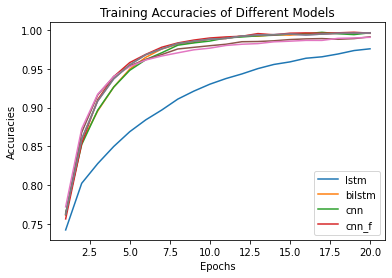

In [ ]:
epochs = [x for x in range(1,21)]
plt.plot(epochs, base_lstm_accuracy)
plt.plot(epochs, bilstm_concat_accuracy)
plt.plot(epochs, bilstm_average_accuracy)
plt.plot(epochs, bilstm_mul_accuracy)
plt.plot(epochs, bilstm_sum_accuracy)
plt.plot(epochs, cnn_accuracy_3)
plt.plot(epochs, cnn_fasttext_accuracy)
plt.plot(epochs, bilstm_sum_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(['lstm', 'bilstm', 'cnn','cnn_f'])
plt.title("Training Accuracies of Different Models")
plt.show()

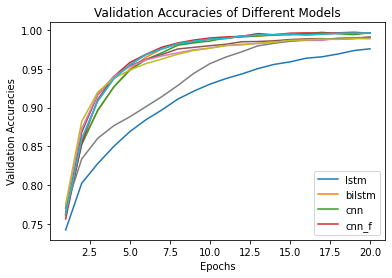

In [ ]:
plt.plot(epochs, base_lstm_validation)
plt.plot(epochs, bilstm__concat_validation)
plt.plot(epochs, bilstm__average_validation)
plt.plot(epochs, bilstm__mul_validation)
plt.plot(epochs, bilstm_sum_validation)
plt.plot(epochs, cnn_validation_3)
plt.plot(epochs, cnn_fasttext_validation)
plt.plot(epochs, cnn2_fasttext_validation_2)
plt.plot(epochs, cnn2_fasttext_validation)
plt.plot(epochs, bilstm_sum_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracies")
plt.legend(['lstm', 'bilstm', 'cnn','cnn_f'])
plt.title("Validation Accuracies of Different Models")
plt.show()
